In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import monai
import torch
import time

print('monai\'s version:', monai.__version__)
print('torch\'s version:', torch.__version__)

In [ ]:
keys = ['img', 'seg']
data_dir = './data/'
fns = os.listdir(data_dir+'img/')
data = [{key: data_dir+key+'/'+fn for key in keys} for fn in fns]
data

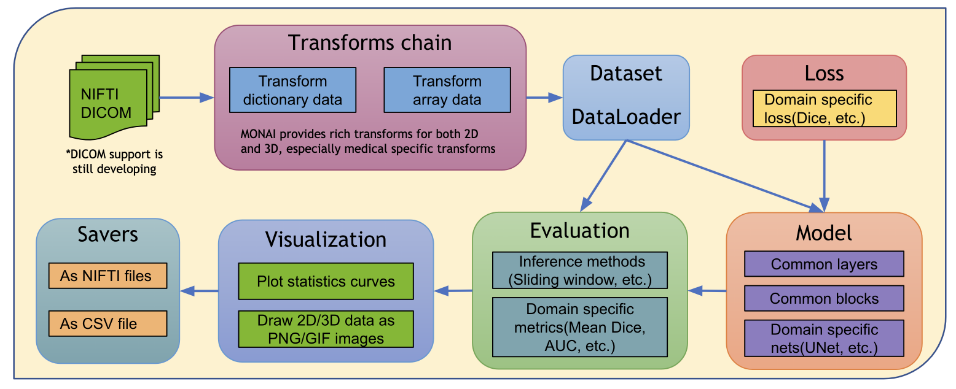

## Transforms
- Data I/O
- Pre-processing
- Augmentation
- Post-processing

In [ ]:
spatial_size = [128, 128, 16]
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  # Data I/O
                                  monai.transforms.AddChanneld(keys),  # Pre-processing
                                  monai.transforms.EnsureTyped(keys),  # Pre-processing
                                  monai.transforms.NormalizeIntensityd(keys='img'),  # Pre-processing
                                  monai.transforms.Resized(keys, spatial_size=spatial_size, mode=['area', 'nearest']),  # Augmentation
                                  monai.transforms.RandScaleIntensityd(keys, 0.2, prob=0.5),  # Augmentation
                                  monai.transforms.RandFlipd(keys, prob=0.5)])  # Augmentation

trans_original = monai.transforms.Compose([monai.transforms.LoadImaged(keys)])

In [ ]:
def plot_trans_imgs(trans1, trans2, data):
    img1 = trans1(data)['img']
    if len(img1.shape)==4:
        img1 = img1[0]
    idx1 = img1.shape[-1]//2
    img2 = trans2(data)['img']
    if len(img2.shape)==4:
        img2 = img2[0]
    idx2 = img2.shape[-1]//2
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(img1[..., idx1], cmap='gray')
    plt.title('Img 1')
    plt.xlabel(str(img1.shape)+', '+str(idx1))
    plt.subplot(122)
    plt.imshow(img2[..., idx2], cmap='gray')
    plt.title('Img 2')
    plt.xlabel(str(img2.shape)+', '+str(idx2))
    plt.show()
    
def plot_trans_imgs_hist(trans1, trans2, data):
    img1 = trans1(data)['img']
    if len(img1.shape)==4:
        img1 = img1[0]
    idx1 = img1.shape[-1]//2
    img2 = trans2(data)['img']
    if len(img2.shape)==4:
        img2 = img2[0]
    idx2 = img2.shape[-1]//2
    
    h = [img1.reshape([-1]), img2.reshape([-1])]
    for i in range(2):
        if type(h[i]) == torch.Tensor:
            h[i] = h[i].numpy()
    
    plt.figure(figsize=(16, 12))
    plt.subplot(221)
    plt.imshow(img1[..., idx1], cmap='gray')
    plt.title('Img 1')
    plt.xlabel(str(img1.shape)+', '+str(idx1))
    plt.subplot(222)
    plt.hist(h[0], bins=30, rwidth=.8)
    plt.title('Img 1')
    plt.xlabel('Mean:'+str(round(h[0].mean(), 4))+', StD:'+str(round(h[0].std(), 4)))
    
    plt.subplot(223)
    plt.imshow(img2[..., idx2], cmap='gray')
    plt.title('Img 2')
    plt.xlabel(str(img2.shape)+', '+str(idx2))
    plt.subplot(224)
    plt.hist(h[1], bins=30, rwidth=.8)
    plt.title('Img 2')
    plt.xlabel('Mean:'+str(round(h[1].mean(), 4))+', StD:'+str(round(h[1].std(), 4)))
    
    plt.show()
    


In [ ]:
plot_trans_imgs_hist(trans_original, trans, data[0])

#### Customize transforms: Lambda

In [ ]:
def sqr(img):
    return img**2

trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys, image_only=True), 
                                  monai.transforms.AddChanneld(keys), 
                                  monai.transforms.Lambdad(keys, sqr)])

plot_trans_imgs_hist(trans_original, trans, data[0])

#### Customize transforms: inherit

In [ ]:
class Sqrd(monai.transforms.MapTransform):
    def __init__(self, params=None):
        self.params = params
        
    def __call__(self, inputs):
        inputs['img'] = inputs['img']**2
        return inputs

trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys, image_only=True), 
                                  monai.transforms.AddChanneld(keys),
                                  Sqrd(keys)])

plot_trans_imgs_hist(trans_original, trans, data[0])

#### Exercise

In [ ]:
# Fix the saveOriginalShaped transform

class SaveOriginalShaped(monai.transforms.MapTransform):
    def __init__(self, img_key, shape_key='ori_shape'):
        self.img_key = img_key
        self.shape_key = shape_key

    def __call__(self, inputs):
        return inputs
    
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys), 
                                  monai.transforms.AddChanneld(keys), 
                                  SaveOriginalShaped('img', 'ori_shape'),
                                  monai.transforms.Resized(keys, spatial_size=(100, 100, 100),),
                                  monai.transforms.ToTensord(keys)])

img_seg = trans(data[0])
print('New shape:', img_seg['img'].shape)
print('Original Shape:', img_seg['ori_shape'])

### ***Data I/O***
---
- monai.transforms.LoadImaged
- monai.transforms.SaveImaged

In [ ]:
trans_io = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                     monai.transforms.SaveImaged(keys='img',
                                                                 output_dir='./',
                                                                 output_postfix='test1',
                                                                 output_ext='.nii.gz',
                                                                 separate_folder=False)])

_ = trans_io(data[0])

### ***Pre-processing***
---

#### Utility
- monai.transforms.AddChanneld
- monai.transforms.EnsureTyped
- monai.transforms.ToTensord

##### **monai.transforms.AddChanneld**
For Conv's matrix computation (channel-first)

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.AddChanneld(keys),]) 

trans_original(data[0])['img'].shape, trans(data[0])['img'].shape

##### **monai.transforms.EnsureTyped**
Ensure the input data to be a PyTorch Tensor or numpy array

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.EnsureTyped(keys, data_type='numpy', dtype=np.float32,),]) 

trans2 = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                   monai.transforms.EnsureTyped(keys)]) 

type(trans_original(data[0])['img']), type(trans(data[0])['img']), type(trans2(data[0])['img'])

##### **monai.transforms.ToTensord**
Convert the input to a torch tensor. Can also choose target device to put the converted data, such as 'cuda' => put the data into GPU

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.ToTensord(keys, dtype=torch.float32, device='cuda')]) 

type(trans_original(data[0])['img']), type(trans(data[0])['img']), trans(data[0])['img'].device

#### Intensity
- monai.transforms.NormalizeIntensityd
- monai.transforms.ScaleIntensityRanged
- monai.transforms.GaussianSmoothd
- monai.transforms.HistogramNormalized

##### **monai.transforms.NormalizeIntensityd**
Normalize input using calculated mean and std by default. You can provide the subtrahend and divisor instead.

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.NormalizeIntensityd(keys, )])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.ScaleIntensityRanged**
Apply specific intensity scaling to the whole numpy array. Scaling from [a_min, a_max] to [b_min, b_max] with clip option.

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                        a_min=-57, a_max=164,
                                                                        b_min=0.0, b_max=1.0),])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.GaussianSmoothd**
Apply Gaussian smooth to the input data based on specified sigma parameter

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.GaussianSmoothd(keys, sigma=1.)])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.HistogramNormalized**
Apply the histogram normalization to input image.

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.HistogramNormalized(keys, min=0, max=1)])

plot_trans_imgs_hist(trans_original, trans, data[0])

#### Spatial
- monai.transforms.SpatialPadd
- monai.transforms.SpatialCropd
- monai.transforms.CropForegroundd
- monai.transforms.Spacingd
- monai.transforms.Resized

##### **monai.transforms.SpatialPadd**
Performs padding to the data, symmetric for all sides or all on one side for each dimension.

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.SpatialPadd(keys, spatial_size=(600, 600, 60), method='symmetric')])

plot_trans_imgs_hist(trans_original, trans, data[0])

In [ ]:
trans2 = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.SpatialPadd(keys, spatial_size=(600, 600, 60), method='end')])

plot_trans_imgs(trans, trans2, data[0])

##### **monai.transforms.SpatialCropd**
General purpose cropper to produce sub-volume region of interest.

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.SpatialCropd(keys, roi_center=(256, 256, 20), roi_size=(256, 256, 16))])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.CropForegroundd**
Crop only the foreground object of the expected images. The typical usage is to help training and evaluation if the valid part is small in the whole medical image. 

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.CropForegroundd(keys, source_key='img')])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.Spacingd**
Resample input image into the specified resolution pixdim (mm). 

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.Spacingd(keys, pixdim=(2, 2, 2))])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.Resized**
Resize the input image to given spatial size

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.Resized(keys, spatial_size=(128, 128, 16))])

plot_trans_imgs_hist(trans_original, trans, data[0])

### ***Augmentation***
---

#### Intensity
- monai.transforms.RandGaussianNoised
- monai.transforms.RandStdShiftIntensityd
- monai.transforms.RandAdjustContrastd

##### **monai.transforms.RandGaussianNoised**
Add Gaussian noise to image with specified mean and std.

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.RandGaussianNoised(keys, prob=0.5, mean=0.0, std=200)])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.RandStdShiftIntensityd**
Randomly scale the intensity of input image by *v = v * (1 + factor)* where the factor is randomly picked.

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.RandStdShiftIntensityd(keys, prob=0.5, factors=0.5, nonzero=False, channel_wise=True, )])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.RandAdjustContrastd**
Randomly changes image intensity by gamma. Each pixel/voxel intensity is updated as:
```
x = ((x - min) / intensity_range) ^ gamma * intensity_range + min
```

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.RandAdjustContrastd(keys, prob=0.5, gamma=(0.5, 4.5))])

plot_trans_imgs_hist(trans_original, trans, data[0])

#### Spatial
- monai.transforms.RandSpatialCropd
- monai.transforms.RandRotated
- monai.transforms.RandRotate90d
- monai.transforms.RandFlipd
- monai.transforms.RandGridDistortiond

##### **monai.transforms.RandSpatialCropd**
Crop image with random size or specific size ROI. It can crop at a random position as center or at the image center.

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.RandSpatialCropd(keys,
                                                                    roi_size=(256, 256, 16),
                                                                    random_center=True,
                                                                    random_size=False)])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.RandRotated**
Randomly rotate the input arrays for each axis.

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.RandRotated(keys, prob=1., range_z=1., keep_size=True, )])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.RandRotate90d**
Input arrays are rotated by 90 degrees in the plane specified by spatial_axes

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.RandRotate90d(keys, prob=0.5, spatial_axes=(0, 1))])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.RandFlip**
Randomly flips the image along axes.

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.RandFlipd(keys, prob=0.5, spatial_axis=(0, 1))])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### monai.transforms.RandGridDistortiond
Random grid distortion, refer to: https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/transforms.py

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.RandGridDistortiond(keys, prob=0.5, distort_limit=0.2)])

plot_trans_imgs_hist(trans_original, trans, data[0])

### ***Post-processing***
---
- monai.transforms.Activationsd
- monai.transforms.AsDiscreted
- monai.transforms.KeepLargestConnectedComponentd
- monai.transforms.Invertd

*Prepare a pre-transform func and a model for post-processing, then do inference*

In [ ]:
from monai.apps.mmars import RemoteMMARKeys
from monai.apps import load_from_mmar

pre_trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys='img'),  
                                      monai.transforms.AddChanneld(keys='img'), 
                                      monai.transforms.Spacingd(keys='img', pixdim=[1.5, 1.5, 2.0], mode='bilinear'),
                                      monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                            a_min=-57, a_max=164,
                                                                            b_min=0.0, b_max=1.0),
                                      monai.transforms.CropForegroundd(keys='img', source_key='img'),
                                      monai.transforms.SpatialCropd(keys='img', roi_center=(100, 100, 49), roi_size=(128, 128, 64)),
                                      monai.transforms.ToTensord(keys='img', device='cuda:0')]) 

def get_mmar_pretrained(mmar_dir='./model/'):
    '''
    Get pre-trained spleen segmentation model from NGC
    mmar_dir: Download the target MMAR to this directory
    '''
    mmar = {
        RemoteMMARKeys.ID: "clara_pt_spleen_ct_segmentation_1",
        RemoteMMARKeys.NAME: "clara_pt_spleen_ct_segmentation",
        RemoteMMARKeys.FILE_TYPE: "zip",
        RemoteMMARKeys.HASH_TYPE: "md5",
        RemoteMMARKeys.HASH_VAL: None,
        RemoteMMARKeys.MODEL_FILE: os.path.join("models", "model.pt"),
        RemoteMMARKeys.CONFIG_FILE: os.path.join("config", "config_train.json"),
        RemoteMMARKeys.VERSION: 1,
    }
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = load_from_mmar(
                item=mmar[RemoteMMARKeys.NAME],
                mmar_dir=mmar_dir,
                map_location=device,
                pretrained=True)
    return model.to(device)

model = get_mmar_pretrained(mmar_dir='./model/')

d = pre_trans(data[0])
d['pred'] = model(d['img'][None, ...])[0]
d['pred'].shape

In [ ]:
def plot_trans_pred_hist(trans1, trans2, data):
    img1 = trans1(data)['pred']
    print('Img 1 original shape:', img1.shape)
    if len(img1.shape)==4:
        img1 = img1[img1.shape[0]-1]
    idx1 = img1.shape[-1]//2
    img2 = trans2(data)['pred']
    print('Img 2 original shape:', img2.shape)
    if len(img2.shape)==4:
        img2 = img2[img2.shape[0]-1]
    idx2 = img2.shape[-1]//2
    plt.figure(figsize=(16, 12))
    plt.subplot(221)
    plt.imshow(img1[..., idx1], cmap='gray')
    plt.title('Img 1')
    plt.xlabel(str(img1.shape)+', '+str(idx1))
    plt.subplot(222)
    plt.hist(img1.reshape([-1]), bins=30, rwidth=.8)
    plt.title('Img 1')
    plt.xlabel('Mean:'+str(round(img1.mean(), 4))+', StD:'+str(round(img1.std(), 4)))
    
    plt.subplot(223)
    plt.imshow(img2[..., idx2], cmap='gray')
    plt.title('Img 2')
    plt.xlabel(str(img2.shape)+', '+str(idx2))
    plt.subplot(224)
    plt.hist(img2.reshape([-1]), bins=30, rwidth=.8)
    plt.title('Img 2')
    plt.xlabel('Mean:'+str(round(img2.mean(), 4))+', StD:'+str(round(img2.std(), 4)))
    
    plt.show()

##### **monai.transforms.Activationsd**
Add activation operations to the model output, typically Sigmoid or Softmax

In [ ]:
original_post_trans = monai.transforms.Compose([monai.transforms.EnsureTyped(keys='pred', data_type='numpy')])

post_trans = monai.transforms.Compose([monai.transforms.Activationsd(keys='pred', softmax=True),
                                       monai.transforms.EnsureTyped(keys='pred', data_type='numpy')])

plot_trans_pred_hist(original_post_trans, post_trans, d)

##### **monai.transforms.AsDiscreted**
Execute after model forward to transform model output to discrete values. 

In [ ]:
original_post_trans = monai.transforms.Compose([monai.transforms.Activationsd(keys='pred', softmax=True),
                                                monai.transforms.EnsureTyped(keys='pred', data_type='numpy')])

post_trans = monai.transforms.Compose([monai.transforms.Activationsd(keys='pred', softmax=True),
                                       monai.transforms.AsDiscreted(keys='pred', argmax=True),
                                       monai.transforms.EnsureTyped(keys='pred', data_type='numpy')])

plot_trans_pred_hist(original_post_trans, post_trans, d)

##### monai.transforms.KeepLargestConnectedComponentd
Keeps only the largest connected component in the image. This transform can be used as a post-processing step to clean up over-segment areas in model output.

In [ ]:
# add fake preds
d['pred'][1, ..., 30:35][80:100, 80:100] = 10

original_post_trans = monai.transforms.Compose([monai.transforms.Activationsd(keys='pred', softmax=True),
                                                monai.transforms.AsDiscreted(keys='pred', argmax=True),
                                                monai.transforms.EnsureTyped(keys='pred', data_type='numpy')])

post_trans = monai.transforms.Compose([monai.transforms.Activationsd(keys='pred', softmax=True),
                                       monai.transforms.AsDiscreted(keys='pred', argmax=True),
                                       monai.transforms.KeepLargestConnectedComponentd(keys='pred', applied_labels=1),
                                       monai.transforms.EnsureTyped(keys='pred', data_type='numpy')])

plot_trans_pred_hist(original_post_trans, post_trans, d)

##### **monai.transforms.Invertd**
Automatically invert the previously applied transforms. A typical usage is to apply the inverse of the preprocessing on input *image* to the model *pred*.

In [ ]:
original_post_trans = monai.transforms.Compose([monai.transforms.EnsureTyped(keys='pred', data_type='numpy')])

post_trans = monai.transforms.Compose([monai.transforms.Invertd(keys='pred',
                                                                transform=pre_trans,
                                                                orig_keys='img',
                                                                meta_keys='pred_meta_dict',
                                                                nearest_interp=True,
                                                                to_tensor=True,
                                                                device='cuda'),
                                       monai.transforms.EnsureTyped(keys='pred', data_type='numpy')])

plot_trans_pred_hist(original_post_trans, post_trans, d)

In [ ]:
original_post_trans = monai.transforms.Compose([monai.transforms.EnsureTyped(keys='pred', data_type='numpy')])

post_trans = monai.transforms.Compose([monai.transforms.Activationsd(keys='pred', softmax=True),
                                       monai.transforms.AsDiscreted(keys='pred', argmax=True),
                                       monai.transforms.KeepLargestConnectedComponentd(keys='pred', applied_labels=1),
                                       monai.transforms.Invertd(keys='pred',
                                                                transform=pre_trans,
                                                                orig_keys='img',
                                                                meta_keys='pred_meta_dict',
                                                                nearest_interp=True,
                                                                to_tensor=True,
                                                                device='cuda'),
                                       monai.transforms.EnsureTyped(keys='pred', data_type='numpy')])

plot_trans_pred_hist(original_post_trans, post_trans, d)

## End-to-end Exercise
Load => Pre-processing => Inference => Post-processing => Save

In [ ]:
# Fix pre_trans:
# - Spacing: [1.5, 1.5, 2.0]
# - Scale intensity range: from [-57, 164] to [0, 1]


pre_trans = monai.transforms.Compose([monai.transforms.LoadImaged(),  
                                      monai.transforms.AddChanneld(), 
                                      monai.transforms.Spacingd(),
                                      monai.transforms.ScaleIntensityRanged(),
                                      monai.transforms.CropForegroundd(),
                                      monai.transforms.ToTensord()]) 

# Fix post_trans:
# - Activation: Softmax
# - Keep largest connected component: applied_labels=1

post_trans = monai.transforms.Compose([monai.transforms.Activationsd(),
                                       monai.transforms.Invertd(keys=,
                                                                transform=,
                                                                orig_keys=,
                                                                meta_keys=,
                                                                nearest_interp=,
                                                                to_tensor=,
                                                                device=),
                                       monai.transforms.AsDiscreted(),
                                       monai.transforms.KeepLargestConnectedComponentd(),
                                       monai.transforms.SaveImaged(keys=,
                                                                   output_dir=',
                                                                   output_postfix=,
                                                                   output_ext='.nii.gz',
                                                                   meta_keys=,
                                                                   resample=,
                                                                   squeeze_end_dims=,
                                                                   separate_folder=)])

#### Process
***Load => Pre-processing*** => Inference => Post-processing => Save

In [ ]:
d = pre_trans(data[0])

Load => Pre-processing => ***Inference*** => Post-processing => Save

In [ ]:
pred = monai.inferers.sliding_window_inference(d['img'][None, ...], sw_batch_size=4, roi_size=(160, 160, 160), overlap=0.5, predictor=model)
d['pred'] = pred[0]

Load => Pre-processing => Inference => ***Post-processing => Save***

In [ ]:
_ = post_trans(d)

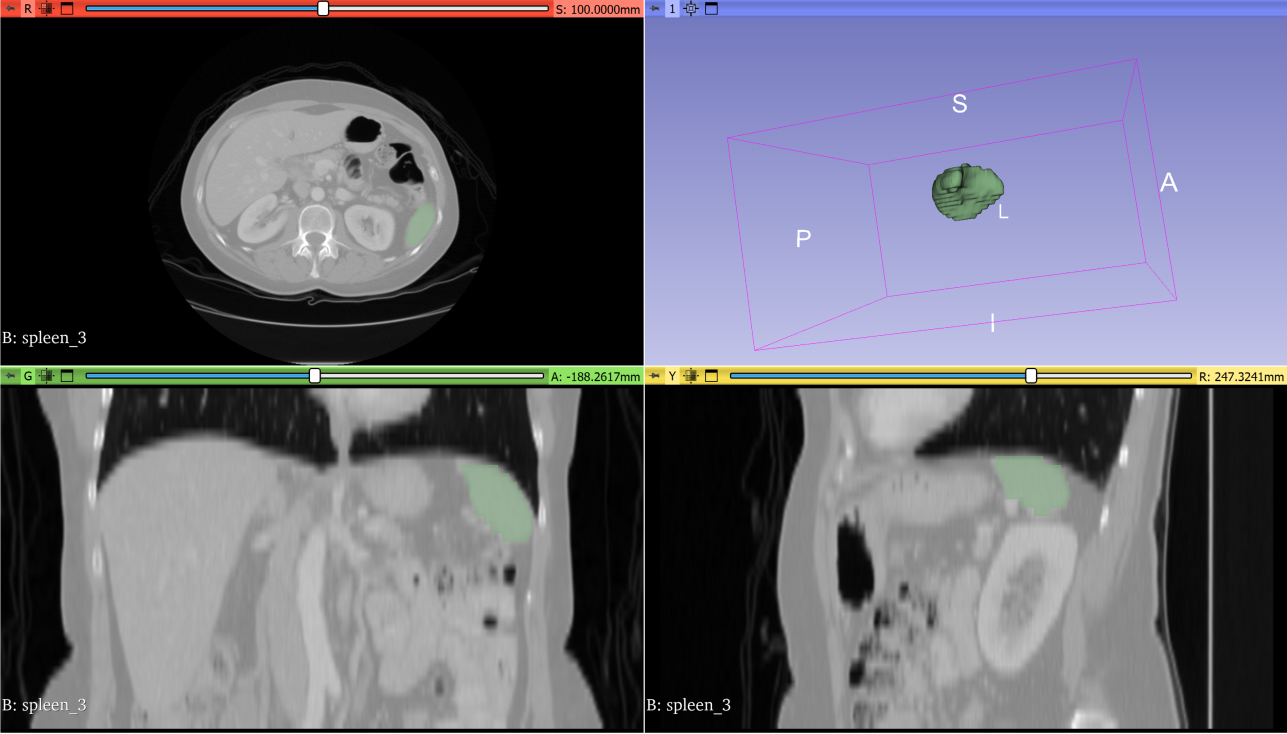

## GPU Accelerated Transforms

In [ ]:
# Without GPU Accelerated

pre_trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys='img'),  
                                      monai.transforms.AddChanneld(keys='img'), 
                                      monai.transforms.Spacingd(keys='img', pixdim=[1.5, 1.5, 2.0], mode='bilinear'),
                                      monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                            a_min=-57, a_max=164,
                                                                            b_min=0.0, b_max=1.0),
                                      monai.transforms.CropForegroundd(keys='img', source_key='img'),
                                      monai.transforms.RandSpatialCropd(keys='img', roi_size=(192, 192, 64)),
                                      monai.transforms.Resized(keys='img', spatial_size=[100, 100, 100]),
                                      monai.transforms.RandFlipd(keys='img', prob=1),
                                      monai.transforms.RandGaussianNoised(keys='img', prob=1, std=0.5),
                                      monai.transforms.ToTensord(keys='img')]) 

dataset = monai.data.CacheDataset(data, transform=pre_trans)

n = 20
t1 = time.time()
for i in range(n):
    for d in dataset:
        _ = d
t2 = time.time()
print(round((t2-t1)/n, 4))

In [ ]:
# With GPU Accelerated

pre_trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys='img'),  
                                      monai.transforms.AddChanneld(keys='img'),
                                      monai.transforms.ToTensord(keys='img', device='cuda'),
                                      monai.transforms.Spacingd(keys='img', pixdim=[1.5, 1.5, 2.0], mode='bilinear'),
                                      monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                            a_min=-57, a_max=164,
                                                                            b_min=0.0, b_max=1.0),
                                      monai.transforms.CropForegroundd(keys='img', source_key='img'),
                                      monai.transforms.RandSpatialCropd(keys='img', roi_size=(192, 192, 64)),
                                      monai.transforms.Resized(keys='img', spatial_size=[100, 100, 100]),
                                      monai.transforms.RandFlipd(keys='img', prob=1),
                                      monai.transforms.RandGaussianNoised(keys='img', prob=1, std=0.5)]) 

dataset = monai.data.CacheDataset(data, transform=pre_trans)

n = 20
t1 = time.time()
for i in range(n):
    for d in dataset:
        _ = d
t2 = time.time()
print(round((t2-t1)/n, 4))